# Reconstructing the tropical Pacific SST with PAGES2k

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)

2024.1.25


## Load the PAGES2k database

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

### Filter the database

We only need the corals in this example.

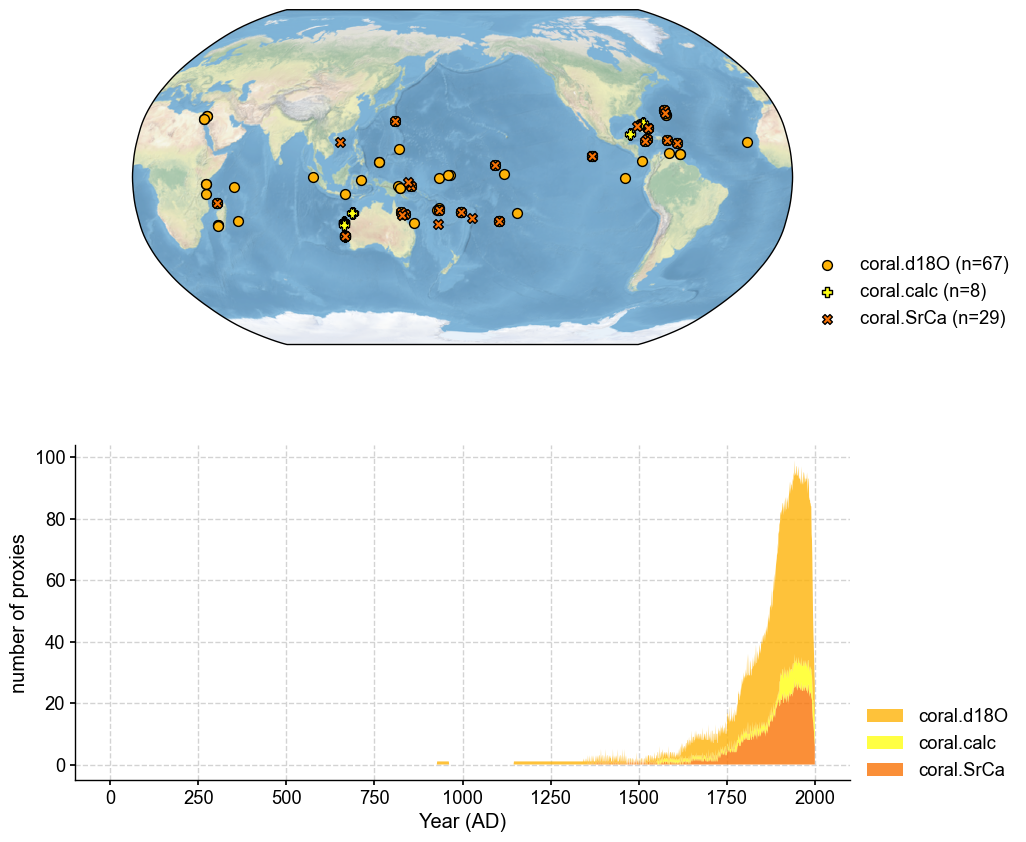

In [3]:
job.filter_proxydb(by='ptype', keys=['coral'])
fig, ax = job.proxydb.plot(plot_count=True)

### Annualize the database

In [4]:
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:01<00:00, 68.57it/s]

>>> 99 records remaining
>>> job.proxydb updated


## Load the gridded climate data

### Load the model prior

In [5]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': 'iCESM_past1000historical/tas',
    },
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


### Load the instrumental observations

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5',
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=(1951, 1980),
)

>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...


## Proxy system modeling

### Calibrating the proxy system models

In [7]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.calc': 'Linear',
    'coral.SrCa': 'Linear',
}

ptype_season_dict = {
    'coral.d18O': [12, 1, 2],
    'coral.calc': [12, 1, 2],
    'coral.SrCa': [12, 1, 2],
}

job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    calib_period=(1850, 2015),
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'coral.d18O': 'Linear', 'coral.SrCa': 'Linear', 'coral.calc': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.d18O': [12, 1, 2], 'coral.SrCa': [12, 1, 2], 'coral.calc': [12, 1, 2]}
>>> job.configs["psm_calib_period"] = (1850, 2015)


Calibrating the PSMs:   7%|▋         | 7/99 [00:00<00:01, 68.33it/s]

The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 20 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  25%|██▌       | 25/99 [00:00<00:00, 80.26it/s]

The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 24 < 25. Skipping ...


Calibrating the PSMs:  62%|██████▏   | 61/99 [00:00<00:00, 81.61it/s]

The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  89%|████████▉ | 88/99 [00:01<00:00, 80.92it/s]

The number of overlapped data points is 21 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 99/99 [00:01<00:00, 79.99it/s]

>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ocn_149 failed to be calibrated.
>>> PSM for Ocn_150 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_152 failed to be calibrated.
>>> PSM for Ocn_164 failed to be calibrated.
>>> PSM for Ocn_165 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ocn_183 failed to be calibrated.
>>> 90 records tagged "calibrated" with ProxyRecord.psm created


### Forwarding the proxy system models

In [8]:
job.forward_psms()

Forwarding the PSMs: 100%|██████████| 90/90 [00:05<00:00, 15.03it/s]


## Annualizing, regridding, and cropping the prior field

In [9]:
job.annualize_clim(tag='prior', months=[12, 1, 2], verbose=True)
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='prior', lat_min=-35, lat_max=35, verbose=True)

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -35
>>> job.configs["prior_lat_max"] = 35
>>> job.configs["prior_lon_min"] = 0
>>> job.configs["prior_lon_max"] = 360
>>> Processing tas ...


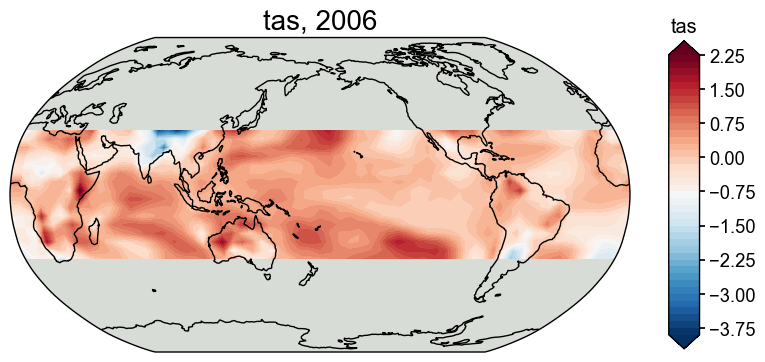

In [10]:
fig, ax = job.prior['tas'][-1].plot()

## Run the DA solver

In [11]:
job.run_da_mc(
    save_dirpath='./recons/lmr-real-pages2k',
    recon_seeds=list(range(1, 11)),
    verbose=True,
)

>>> job.configs["recon_period"] = [0, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr-real-pages2k
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:16<00:00, 118.59it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:19<00:00, 105.25it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r02_recon.nc
>>> seed: 3 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:18<00:00, 105.46it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r03_recon.nc
>>> seed: 4 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:21<00:00, 93.20it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r04_recon.nc
>>> seed: 5 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:24<00:00, 82.18it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r05_recon.nc
>>> seed: 6 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:25<00:00, 77.23it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r06_recon.nc
>>> seed: 7 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:19<00:00, 103.95it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r07_recon.nc
>>> seed: 8 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:20<00:00, 96.38it/s]  


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r08_recon.nc
>>> seed: 9 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:18<00:00, 110.38it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r09_recon.nc
>>> seed: 10 | max: 10


KF updating: 100%|██████████| 2001/2001 [00:16<00:00, 121.87it/s] 


>>> Reconstructed fields saved to: ./recons/lmr-real-pages2k/job_r10_recon.nc
>>> DONE! Total time spent: 4.90 mins.


## Validate the reconstruction

In [12]:
res = cfr.ReconRes('./recons/lmr-real-pages2k')
res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


### Load the 20CRv3 as our validation target

In [13]:
target = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980))

>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


In [14]:
target = target.annualize(months=[12, 1, 2]).crop(lat_min=-35, lat_max=35)
target.da

<xarray.DataArray 'tas' (time: 211, lat: 71, lon: 360)>
array([[[-0.91856384, -0.91993713, -0.90966797, ..., -0.85354614,
         -0.85147095, -0.85954285],
        [-0.8273926 , -0.8347168 , -0.8584137 , ..., -0.74972534,
         -0.7395172 , -0.76701355],
        [-0.7059021 , -0.71569824, -0.74658203, ..., -0.6398926 ,
         -0.644989  , -0.67285156],
        ...,
        [ 0.55033875,  0.47299194,  0.4526825 , ...,  0.832077  ,
          0.6897583 ,  0.6489868 ],
        [ 0.8533478 ,  0.5409241 ,  0.37857056, ...,  0.8107605 ,
          0.44779968,  0.5542908 ],
        [ 0.6942291 ,  0.7193756 ,  0.7677002 , ...,  0.5063324 ,
          0.51849365,  0.45474243]],

       [[-0.86241657, -0.86223346, -0.8687134 , ..., -0.8400472 ,
         -0.8293762 , -0.83046466],
        [-0.791687  , -0.8050334 , -0.8434143 , ..., -0.714742  ,
         -0.72177124, -0.75076294],
        [-0.70229083, -0.7283732 , -0.7738342 , ..., -0.6168518 ,
         -0.6468099 , -0.67786664],
...
        [-0.7697449 , -0.6768901 , -0.5923462 , ..., -0.56062824,
         -0.68392944, -0.78031415],
        [-0.87024945, -0.837382  , -0.76048785, ..., -0.61620075,
         -0.72455853, -0.82958984],
        [-0.6300557 , -0.6863912 , -0.7022502 , ..., -0.12608846,
         -0.24433391, -0.4693502 ]],

       [[ 1.1114197 ,  1.1156616 ,  1.1440125 , ...,  1.1346741 ,
          1.0916748 ,  1.070221  ],
        [ 0.9642334 ,  1.019104  ,  1.1342773 , ...,  1.1085205 ,
          1.0567322 ,  0.9859314 ],
        [ 0.92681885,  0.9468384 ,  0.9932251 , ...,  1.0208435 ,
          1.0012512 ,  0.94000244],
        ...,
        [ 1.573761  ,  1.3674316 ,  1.1996155 , ...,  2.4711304 ,
          2.2483215 ,  1.8666077 ],
        [ 2.556244  ,  2.3460693 ,  2.0101624 , ...,  3.1957703 ,
          3.0577087 ,  2.749237  ],
        [ 3.0726013 ,  2.9905396 ,  2.7269592 , ...,  2.7269897 ,
          2.9135742 ,  3.011139  ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -35.0 -34.0 -33.0 -32.0 -31.0 ... 32.0 33.0 34.0 35.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 1806 1807 1808 1809 1810 ... 2012 2013 2014 2015 2016
Attributes:
    annualized:  1

### Field validation

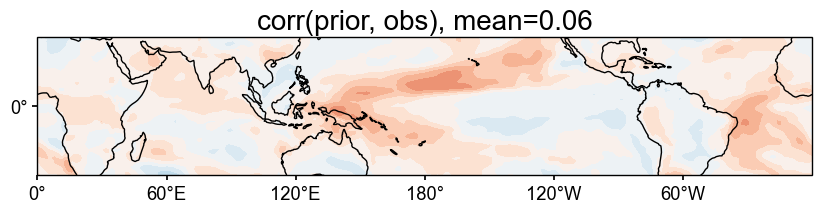

Figure saved at: "figs/pda_corr_prior_obs.pdf"


In [15]:
# validate the prior against 20CR
stat = 'corr'

valid_fd = job.prior['tas'].compare(
    target, stat=stat,
    timespan=(1874, 2000),
)

fig, ax = valid_fd.plot(
    title=f'{stat}(prior, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_{stat}_prior_obs.pdf')

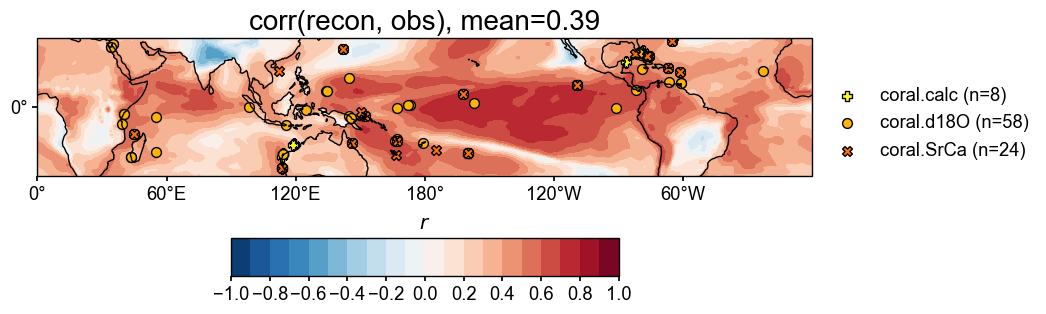

Figure saved at: "figs/pda_corr_recon_obs.pdf"


In [19]:
# validate the reconstruction against 20CR
valid_fd = res.recons['tas'].compare(
    target, stat=stat,
    timespan=(1874, 2000),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=True, plot_proxydb=True, proxydb=job.proxydb.filter(by='tag', keys=['calibrated']),
    plot_proxydb_lgd=True, proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_{stat}_recon_obs.pdf')

### Timeseries validation

In [17]:
bc09 = cfr.EnsTS().fetch('BC09_NINO34')
bc09_ann = bc09.annualize(months=[12, 1, 2])

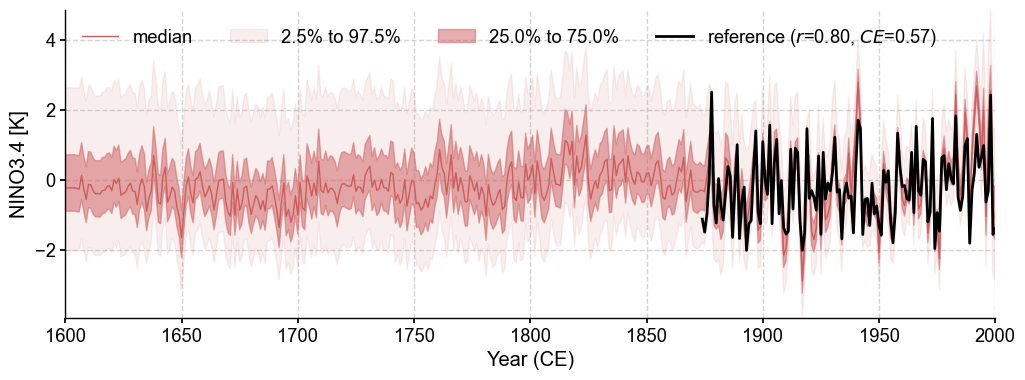

Figure saved at: "figs/pda_corr_recon_BC09.pdf"


In [18]:
fig, ax = res.recons['nino3.4'].compare(bc09_ann, timespan=(1874, 2000)).plot_qs()
ax.set_xlim(1600, 2000)
ax.set_ylabel('NINO3.4 [K]')
cfr.showfig(fig)
cfr.savefig(fig, f'./figs/pda_corr_recon_BC09.pdf')